<a href="https://colab.research.google.com/github/RuslanDulaev/Rainfall_prediction/blob/main/rainfall.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [108]:
df = pd.read_csv('/content/rain_train.csv', index_col='id')
df.shape

(2190, 12)

Проверка на пустые значения

In [109]:
df.isnull().sum()

,0
day,0
pressure,0
maxtemp,0
temparature,0
mintemp,0
dewpoint,0
humidity,0
cloud,0
sunshine,0
winddirection,0


In [110]:
df.dtypes

,0
day,int64
pressure,float64
maxtemp,float64
temparature,float64
mintemp,float64
dewpoint,float64
humidity,float64
cloud,float64
sunshine,float64
winddirection,float64


# EDA

In [111]:
matrix_correlation = df.corr()

<Axes: >

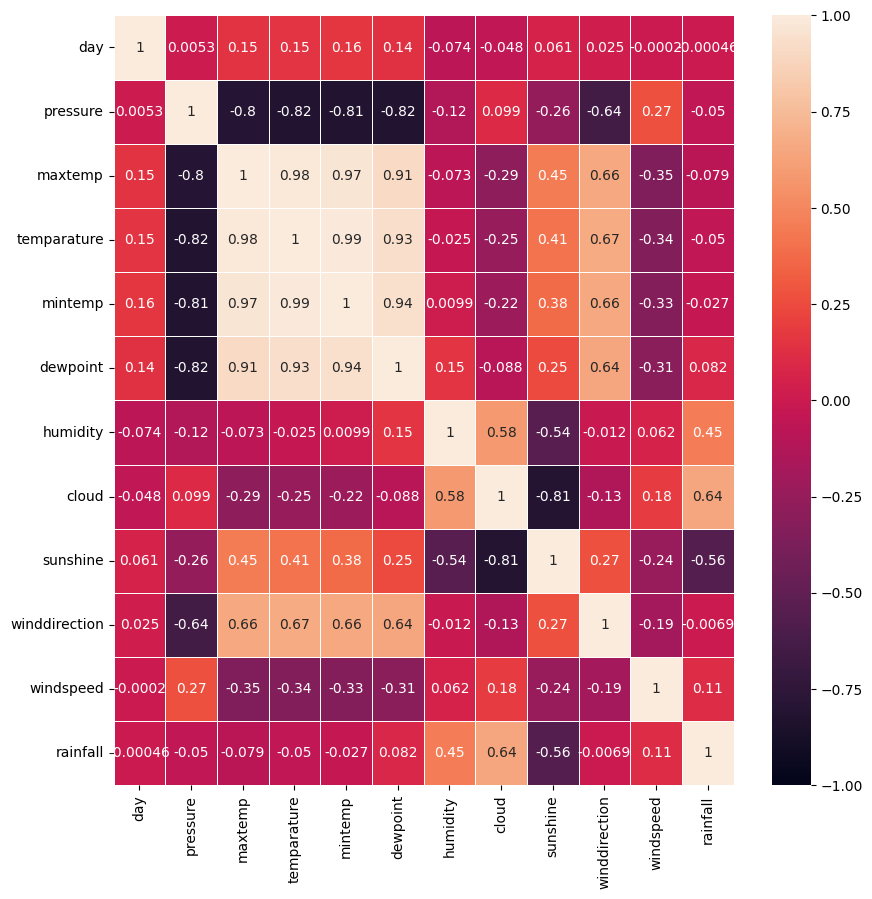

In [112]:
plt.figure(figsize=(10, 10))
sns.heatmap(matrix_correlation, annot=True, vmin=-1, vmax=1, linewidths=0.5)

array([[<Axes: title={'center': 'day'}>,
        <Axes: title={'center': 'pressure'}>,
        <Axes: title={'center': 'maxtemp'}>],
       [<Axes: title={'center': 'temparature'}>,
        <Axes: title={'center': 'mintemp'}>,
        <Axes: title={'center': 'dewpoint'}>],
       [<Axes: title={'center': 'humidity'}>,
        <Axes: title={'center': 'cloud'}>,
        <Axes: title={'center': 'sunshine'}>],
       [<Axes: title={'center': 'winddirection'}>,
        <Axes: title={'center': 'windspeed'}>,
        <Axes: title={'center': 'rainfall'}>]], dtype=object)

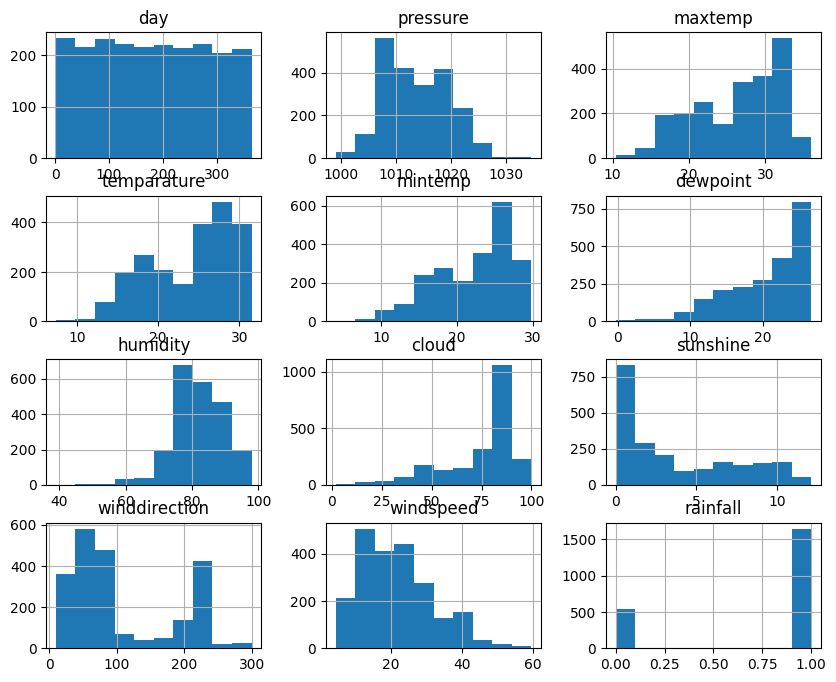

In [113]:
df.hist(figsize=(10,8))

In [114]:
columns_for_box = df.drop(columns=['day', 'rainfall'])
columns_for_box

,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
id,,,,,,,,,,
0,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2
1,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9
2,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1
3,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6
4,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8
...,...,...,...,...,...,...,...,...,...,...
2185,1014.6,23.2,20.6,19.1,19.9,97.0,88.0,0.1,40.0,22.1
2186,1012.4,17.2,17.3,16.3,15.3,91.0,88.0,0.0,50.0,35.3
2187,1013.3,19.0,16.3,14.3,12.6,79.0,79.0,5.0,40.0,32.9


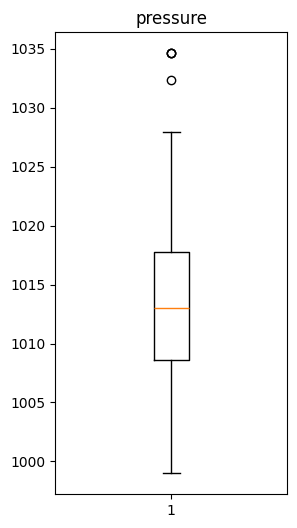

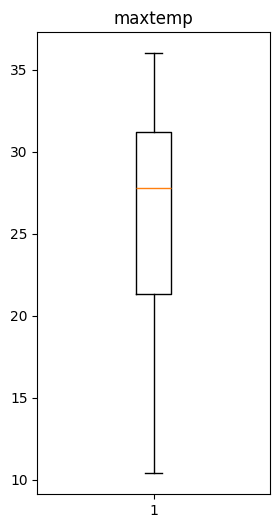

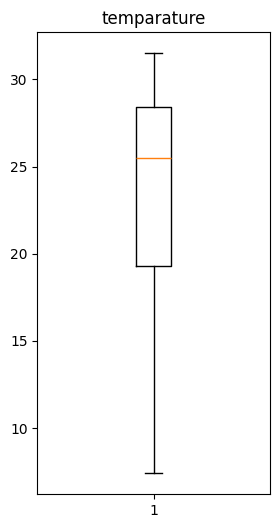

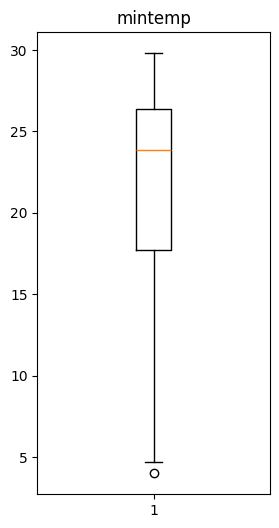

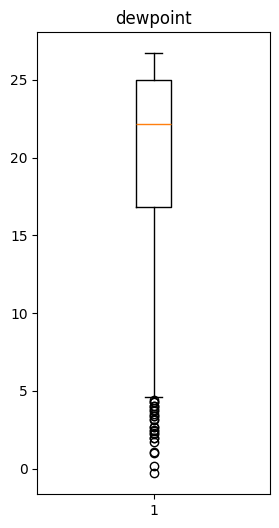

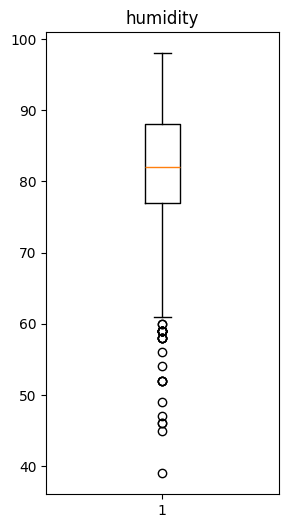

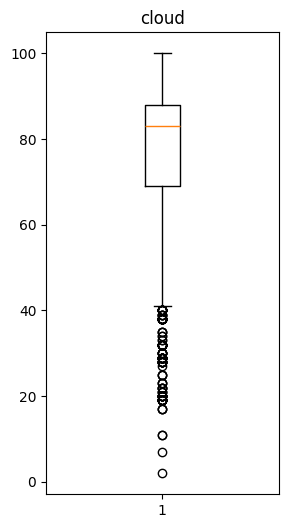

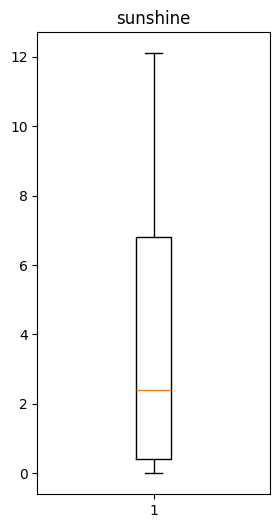

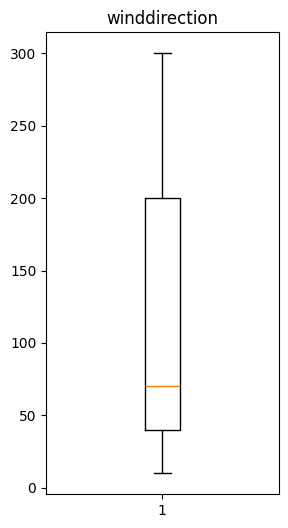

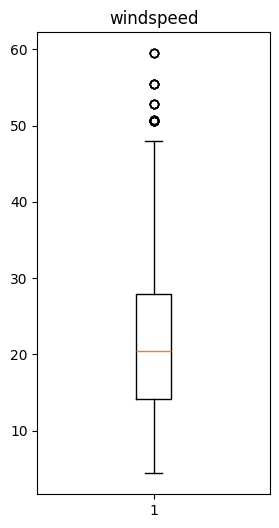

In [115]:
for column in columns_for_box:
  plt.figure(figsize=(3, 6))
  plt.boxplot(columns_for_box[column])
  plt.title(column)
  plt.show()

Разделение данных на предикторы и целевую переменную

In [116]:
X = df.drop('rainfall', axis=1)
y = df['rainfall']

In [117]:
print(X.shape)
print(y.shape)

(2190, 11)
(2190,)


# Feature Engineering

In [118]:
X['temp_range'] = X['maxtemp'] - X['mintemp']
X['month'] = pd.to_datetime(X['day'], format='%j').dt.month_name()

In [119]:
X.shape

(2190, 13)

# One-hot encoding

In [120]:
X.drop(columns=['day'], inplace=True)
X = pd.get_dummies(X)

In [121]:
X.shape

(2190, 23)

In [122]:
# Данные для submission на Kaggle
submission_test = pd.read_csv('/content/test.csv', index_col='id')
idies = submission_test.index

submission_test['temp_range'] = submission_test['maxtemp'] - submission_test['mintemp']
submission_test['month'] = pd.to_datetime(submission_test['day'], format='%j').dt.month_name()

submission_test.drop(columns=['day'], inplace=True)
submission_test = pd.get_dummies(submission_test)

Деление данных на train и test

In [123]:
from sklearn.model_selection import train_test_split

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [125]:
print(X_train.shape)
print(X_test.shape)

(1467, 23)
(723, 23)


Обучение на основе DecisionTreeClassifier с использованием GridSearchCV

In [126]:
from sklearn import tree
from sklearn.model_selection import GridSearchCV

In [127]:
model = tree.DecisionTreeClassifier()
parameters = {'criterion': ['gini', 'entropy'], 'max_depth': range(1, 10)}

In [128]:
grid_search_cv_clf = GridSearchCV(model, parameters, cv=5)

In [129]:
grid_search_cv_clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 10)})

In [130]:
grid_search_cv_clf.best_params_

{'criterion': 'entropy', 'max_depth': 4}

In [131]:
best_model = grid_search_cv_clf.best_estimator_

In [132]:
best_model.score(X_train, y_train)

0.8841172460804363

In [133]:
best_model.score(X_test, y_test)

0.8437067773167358

Предсказание для Kaggle 1

In [136]:
prediction = best_model.predict(submission_test)
pred_df = pd.DataFrame(prediction, index=idies, columns=['rainfall'])
pred_df.to_csv('submission.csv', encoding='utf-8')

Обучение на основе RandomForestClassifier с использованием GridSearchCV



In [137]:
from sklearn.ensemble import RandomForestClassifier

In [138]:
second_model = RandomForestClassifier()
parameters = {'criterion': ['gini', 'entropy'], 'max_depth': range(1, 5)}

In [139]:
grid_search_cv_clf_2 = GridSearchCV(second_model, parameters, cv=5)

In [140]:
grid_search_cv_clf_2.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 5)})

In [141]:
best_clf_2 = grid_search_cv_clf_2.best_estimator_

In [143]:
best_clf_2.score(X_train, y_train)

0.89093387866394

In [144]:
best_clf_2.score(X_test, y_test)

0.8575380359612724

Предсказание для Kaggle 2

In [142]:
predictions_2 = best_clf_2.predict(submission_test)
pred_df_2 = pd.DataFrame(predictions_2, index=idies, columns=['rainfall'])
pred_df_2.to_csv('submission_2.csv', encoding='utf-8')

Обучение модели RandomForestClassifier вместе со Scaling

In [145]:
from sklearn.preprocessing import MinMaxScaler

In [146]:
numeric_cols = ['pressure',	'maxtemp', 'temparature',	'mintemp',	'dewpoint',	'humidity',	'cloud',	'sunshine',	'winddirection', 'windspeed']

In [147]:
scaler = MinMaxScaler().fit(X_train[numeric_cols])

In [148]:
X_train[numeric_cols] = scaler.transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [149]:
grid_search_cv_clf_2.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 5)})

In [150]:
best_clf_2 = grid_search_cv_clf_2.best_estimator_

In [151]:
best_clf_2.score(X_test, y_test)

0.8533886583679114

Предсказания для Kaggle 3

In [152]:
predictions_3 = best_clf_2.predict(submission_test)
pred_df_2 = pd.DataFrame(predictions_2, index=idies, columns=['rainfall'])
pred_df_2.to_csv('submission_3.csv', encoding='utf-8')

Как мы можем видеть, масштабирование предикторов положительно повлияли на прогноз нашей модели

Теперь попробуем обучить на основе LogisticRegression

In [153]:
from sklearn.linear_model import LogisticRegression

In [154]:
third_model = LogisticRegression()

In [155]:
third_model.fit(X_train, y_train)

LogisticRegression()

In [156]:
third_model.score(X_train, y_train)

0.8718473074301295

In [157]:
third_model.score(X_test, y_test)

0.8589211618257261

In [158]:
submission_test.isnull().sum()
submission_test['winddirection'].fillna(submission_test['winddirection'].mean(), inplace=True)

<ipython-input-158-430e1e901221>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  submission_test['winddirection'].fillna(submission_test['winddirection'].mean(), inplace=True)


Предсказания для Kaggle 4

In [159]:
predictions_4 = third_model.predict(submission_test)
pred_df_4= pd.DataFrame(predictions_4, index=idies, columns=['rainfall'])
pred_df_4.to_csv('submission_4.csv', encoding='utf-8')

Обучение на основе XGBRegressor

In [160]:
from xgboost import XGBRegressor

In [161]:
fourth_model = XGBRegressor()

In [162]:
fourth_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [163]:
fourth_model.score(X_train, y_train)

0.9960871338844299

In [164]:
fourth_model.score(X_test, y_test)

0.32331383228302

Как мы можем наблюдать, происходит сильное переобучение нашей модели. Необходимо подобрать более оптимальные параметры.